# 学習の目標
- 代表的なCNNのモデルであるResNetやWideResNetについて理解する
- CIFAR-10のデータセットを利用してResNet・WideResNetのモデルの実装ができる

## 事前準備
-  このチュートリアルではGPUを用いて処理を行うために、上部のメニューバーの「ランタイム」→「ランタイムのタイプを変更」からハードウェアアクセラレータをGPUに設定して下さい

In [ ]:
# GPUの確認(出力結果がcpuになった場合は上記の手順でランタイムをGPUに変更して下さい)
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## ResNet(Residual Networks)とは
ResNetは2015年のILSVRCの優勝モデルです。  
ディープラーニングにおいてネットワークを深くするほど表現能力が向上し、認識精度は向上します。ただ層を深くしすぎた場合に勾配消失問題などが原因で効率的な学習ができないことが問題となっていました。

ResNetは、一般的なニューラルネットワークのように、何らかの処理を施した変換$F(x)$を単純に次の層に渡していくのではなく、スキップ構造という層を飛び越えた結合を作成し、$H(x)=F(x)+x$を次の層に渡すようにしています。これにより深い層において勾配消失が発生したとしても、層を跨いで値を伝播することが可能になりました。このショートカットを含めた処理体型をResidual blockと呼びます。このスキップ構造によって非常に深いネットワークでも効率的な学習が可能となり、152層のResNetのモデルも公開されています。








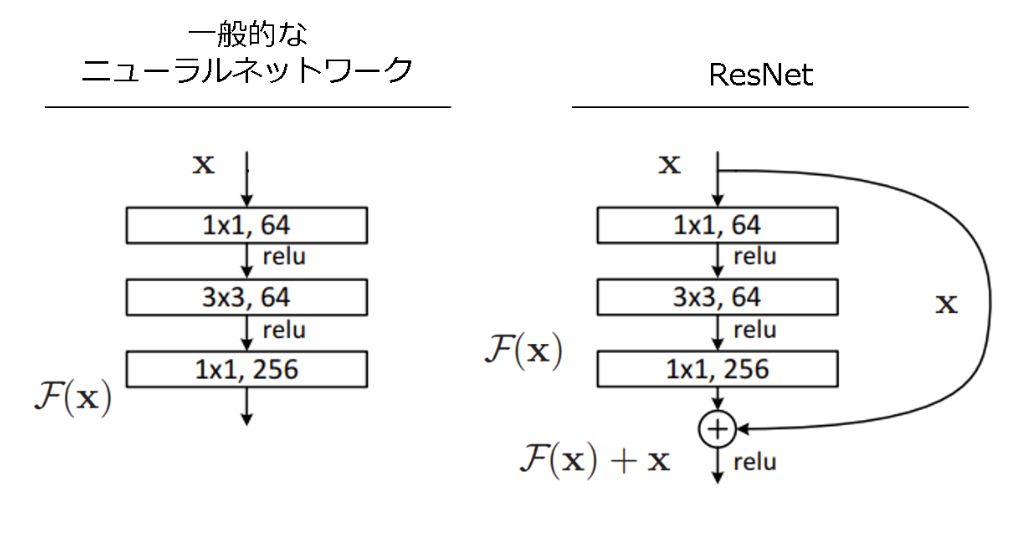


ResNetには層の数に合わせてResNet34、ResNet50、ResNet101などの種類があります。
今回はResNet50を使って学習をしてみます。

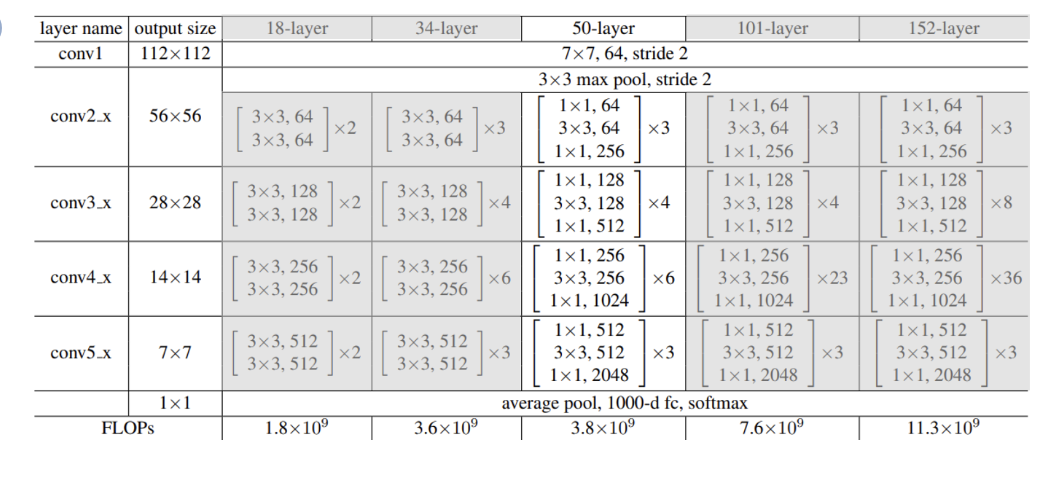

**残差ブロック**<br>
ResNetの構築は主要パーツとなる残差ブロックのクラスを作成します。<br>
今回は学習済みのネットワークをpytorchからインポートして使用しますので、構築は必要ありませんが、自分で実装される際には参考にして下さい。
残差ブロックの基本的な構造はどれも同じですが、inputとoutputのchannel数、sizeによって主に3パターンに分けることができます。

- パターン1 inputとoutputでchannel数、sizeが同じ
- パターン2 outputのchannel数がinputの4倍
- パターン3 outputのchannel数がinputの4倍、且つ、outputのsizeがinputの1/2

目的・目標に合わせて、クラスを設計します。
パターン2はidentify(元の入力値)を足す際にchannel数が合わなくなってしまうため、identifyを足す前に1×1のconv層を通すことでoutput channelを調整します(identity_conv)。パターン3は、残差ブロック内の3×3のconv層のstrideを2にすることでサイズを半分にします。


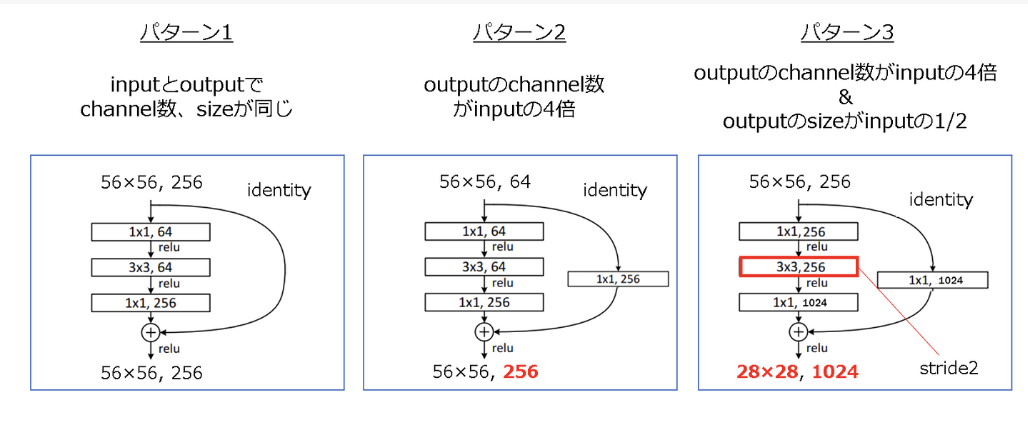

## モジュールのインポート

In [ ]:
# PyTooch関連ライブラリインポート
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

# それ以外のライブラリインポート
%matplotlib inline
from tqdm import tqdm
import numpy as np
!pip install japanize_matplotlib | tail -n 1
import matplotlib.pyplot as plt
import japanize_matplotlib

## 学習データの準備

In [ ]:
# 分類クラス数
num_classes = 10

# 学習繰り返し回数
nb_epoch = 20

# 1回の学習で何枚の画像を使うか
batch_size = 128

In [ ]:
# 学習データの読み込み
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:01<00:00, 102819960.32it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### 画像の表示

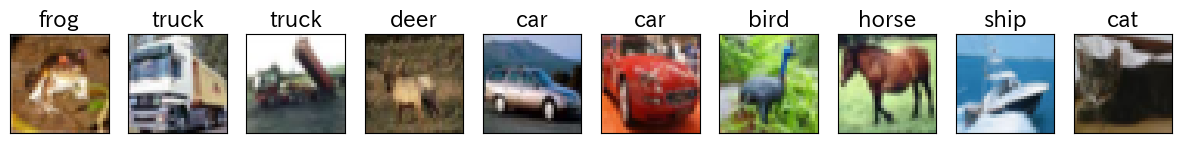

In [ ]:
plt.figure(figsize=(15, 4))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    image, label = trainset[i]
    np_image = image.numpy().copy()
    img = np.transpose(np_image, (1, 2, 0))
    img2 = (img + 1)/2
    plt.imshow(img2)
    ax.set_title(classes[label], fontsize=16)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# 訓練データ用: 正規化に追加で反転とRandomErasingを実施
transform_train = transforms.Compose([
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.ToTensor(),
  transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
  transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

# 検証データ用 : 正規化のみ実施
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

## 学習済みモデル(ResNet)の読み込み

In [ ]:
# 学習済みモデルの読み込み
# Resnet50を重み付きで読み込む
model_ft = models.resnet50(pretrained = True)

# 最終ノードの出力を10に変更する
model_ft.fc = nn.Linear(model_ft.fc.in_features, 10)

# GPUの利用
net = model_ft.to(device)

# 損失関数に交差エントロピーを利用
criterion = nn.CrossEntropyLoss()

# 最適化に関しては、いくつかのパターンを調べた結果、下記が一番結果がよかった
optimizer = optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 231MB/s]


In [ ]:
# 読み込んだモデルの表示
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# モデルのサマリーの表示
summary(net,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

## モデルの学習(ResNet)

In [ ]:
# ハイパーパラメータの設定
nb_epoch= 20 #　学習回数
batch_size =128 # 1回の学習で使う画像数
lr = 0.001 # 学習率

In [ ]:
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
e_sum = 0

for i in range(nb_epoch):
  train_loss = 0
  train_acc = 0
  val_loss = 0
  val_acc = 0

  #学習
  net.train()

  for images, labels in tqdm(train_loader):

    #勾配の初期化(ループの頭でやる必要あり)
    optimizer.zero_grad()

    # 訓練データの準備
    images = images.to(device)
    labels = labels.to(device)

    # 順伝搬計算
    outputs = net(images)

    # 誤差計算
    loss = criterion(outputs, labels)
    train_loss += loss.item()

    # 学習
    loss.backward()
    optimizer.step()

    #予測値算出
    predicted = outputs.max(1)[1]

    #正解件数算出
    train_acc += (predicted == labels).sum()

  # 訓練データに対する損失と精度の計算
  avg_train_loss = train_loss / len(train_loader.dataset)
  avg_train_acc = train_acc / len(train_loader.dataset)

  #評価
  net.eval()
  with torch.no_grad():

    for images, labels in test_loader:

      # テストデータの準備
      images = images.to(device)
      labels = labels.to(device)

      # 順伝搬計算
      outputs = net(images)

      # 誤差計算
      loss = criterion(outputs, labels)
      val_loss += loss.item()

      #予測値算出
      predicted = outputs.max(1)[1]

      #正解件数算出
      val_acc += (predicted == labels).sum()

    # 検証データに対する損失と精度の計算
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)

  print (f'Epoch [{(i+1)}/{nb_epoch}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
  train_loss_list.append(avg_train_loss)
  train_acc_list.append(avg_train_acc)
  val_loss_list.append(avg_val_loss)
  val_acc_list.append(avg_val_acc)

100%|██████████| 391/391 [00:34<00:00, 11.49it/s]


Epoch [1/20], loss: 0.00866 acc: 0.61410 val_loss: 0.00551, val_acc: 0.76100


100%|██████████| 391/391 [00:25<00:00, 15.18it/s]


Epoch [2/20], loss: 0.00418 acc: 0.81662 val_loss: 0.00474, val_acc: 0.79680


100%|██████████| 391/391 [00:28<00:00, 13.69it/s]


Epoch [3/20], loss: 0.00257 acc: 0.88972 val_loss: 0.00482, val_acc: 0.80590


100%|██████████| 391/391 [00:26<00:00, 14.86it/s]


Epoch [4/20], loss: 0.00147 acc: 0.93830 val_loss: 0.00525, val_acc: 0.80790


100%|██████████| 391/391 [00:26<00:00, 14.67it/s]


Epoch [5/20], loss: 0.00092 acc: 0.96146 val_loss: 0.00585, val_acc: 0.80330


100%|██████████| 391/391 [00:28<00:00, 13.64it/s]


Epoch [6/20], loss: 0.00060 acc: 0.97520 val_loss: 0.00633, val_acc: 0.80720


100%|██████████| 391/391 [00:29<00:00, 13.31it/s]


Epoch [7/20], loss: 0.00045 acc: 0.98192 val_loss: 0.00656, val_acc: 0.80940


100%|██████████| 391/391 [00:26<00:00, 14.62it/s]


Epoch [8/20], loss: 0.00039 acc: 0.98366 val_loss: 0.00675, val_acc: 0.81030


100%|██████████| 391/391 [00:26<00:00, 14.53it/s]


Epoch [9/20], loss: 0.00038 acc: 0.98400 val_loss: 0.00691, val_acc: 0.81360


100%|██████████| 391/391 [00:30<00:00, 12.89it/s]


Epoch [10/20], loss: 0.00033 acc: 0.98666 val_loss: 0.00687, val_acc: 0.82140


100%|██████████| 391/391 [00:28<00:00, 13.65it/s]


Epoch [11/20], loss: 0.00028 acc: 0.98798 val_loss: 0.00698, val_acc: 0.82060


100%|██████████| 391/391 [00:28<00:00, 13.82it/s]


Epoch [12/20], loss: 0.00025 acc: 0.99006 val_loss: 0.00691, val_acc: 0.81910


100%|██████████| 391/391 [00:28<00:00, 13.86it/s]


Epoch [13/20], loss: 0.00019 acc: 0.99248 val_loss: 0.00707, val_acc: 0.81700


100%|██████████| 391/391 [00:29<00:00, 13.37it/s]


Epoch [14/20], loss: 0.00017 acc: 0.99336 val_loss: 0.00734, val_acc: 0.82000


100%|██████████| 391/391 [00:30<00:00, 12.65it/s]


Epoch [15/20], loss: 0.00014 acc: 0.99488 val_loss: 0.00748, val_acc: 0.82050


100%|██████████| 391/391 [00:28<00:00, 13.86it/s]


Epoch [16/20], loss: 0.00013 acc: 0.99454 val_loss: 0.00758, val_acc: 0.81900


100%|██████████| 391/391 [00:30<00:00, 12.84it/s]


Epoch [17/20], loss: 0.00013 acc: 0.99452 val_loss: 0.00740, val_acc: 0.82270


100%|██████████| 391/391 [00:33<00:00, 11.57it/s]


Epoch [18/20], loss: 0.00012 acc: 0.99498 val_loss: 0.00763, val_acc: 0.82290


100%|██████████| 391/391 [00:25<00:00, 15.16it/s]


Epoch [19/20], loss: 0.00009 acc: 0.99628 val_loss: 0.00758, val_acc: 0.82560


100%|██████████| 391/391 [00:25<00:00, 15.10it/s]


Epoch [20/20], loss: 0.00011 acc: 0.99542 val_loss: 0.00750, val_acc: 0.82230


## 学習曲線の表示(ResNet)

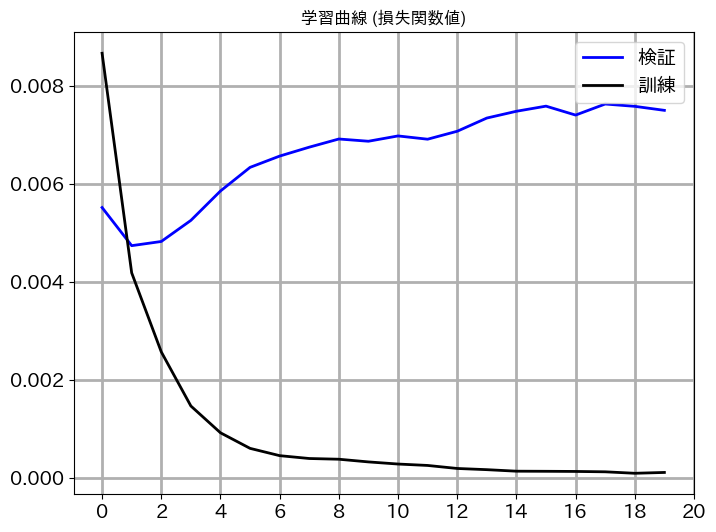

In [ ]:
# 学習曲線 (損失関数値)
plt.figure(figsize=(8,6))
plt.plot(val_loss_list,label='検証', lw=2, c='b')
plt.plot(train_loss_list,label='訓練', lw=2, c='k')
plt.title('学習曲線 (損失関数値)')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.xticks(np.arange(0, 21, 2))
plt.show()

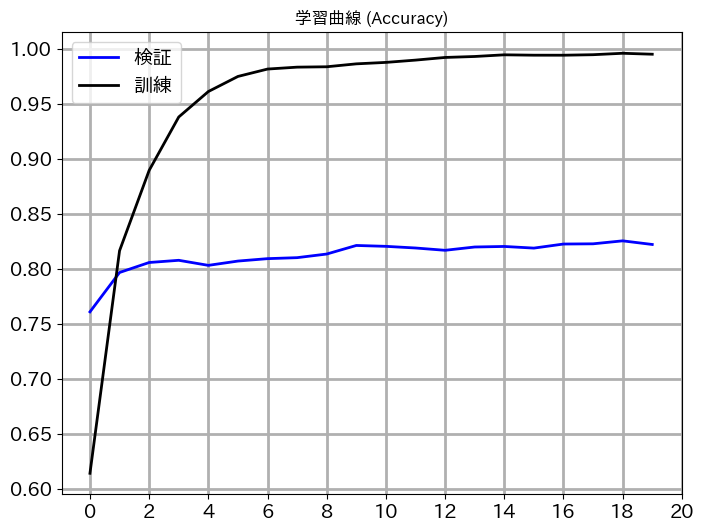

In [ ]:
val_acc_list_x = []
train_acc_list_x = []

for x in val_acc_list:
  t = x.to('cpu').detach().numpy().copy()
  val_acc_list_x.append(t)

for z in train_acc_list:
  s = z.to('cpu').detach().numpy().copy()
  train_acc_list_x.append(s)

# 学習曲線 (Accuracy)
plt.figure(figsize=(8,6))
plt.plot(val_acc_list_x,label='検証', lw=2, c='b')
plt.plot(train_acc_list_x,label='訓練', lw=2, c='k')
plt.title('学習曲線 (Accuracy)')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.xticks(np.arange(0, 21, 2))
plt.show()

## WideResNetとは

WideResNetはResNetのフィルタ数を増やすことで、GPUを活用し、浅いネットワークで,深いネットワークと同等の表現力を持つように改良したモデルです。  
kが広さの係数となっており、k=1でオリジナルのResNetのモデルと同じになります。


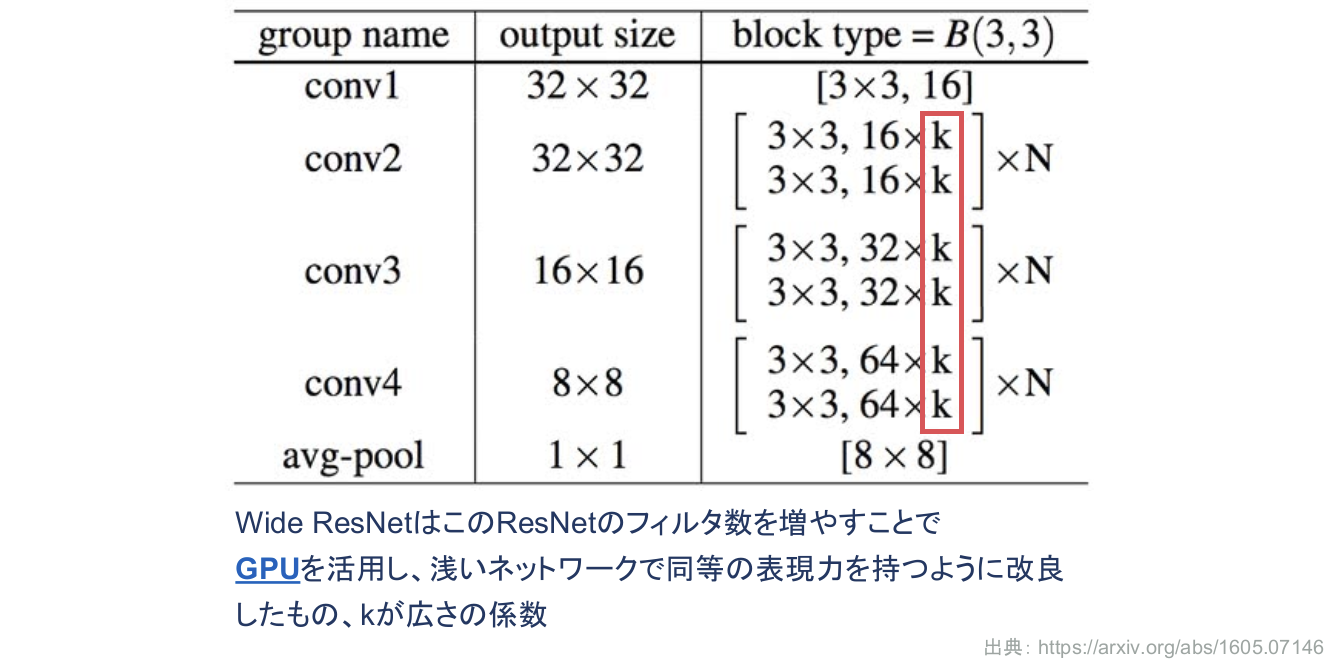

## 学習済みモデル(WideResNet)の読み込み

In [ ]:
# 学習済みモデルの読み込み
# wide_Resnet50を重み付きで読み込む
model_wr = models.wide_resnet50_2(pretrained=True)

# 最終ノードの出力を10に変更する
model_wr.fc = nn.Linear(model_wr.fc.in_features, 10)

# GPUの利用
net_wr = model_wr.to(device)

# 損失関数に交差エントロピーを利用
criterion = nn.CrossEntropyLoss()

# 最適化に関しては、いくつかのパターンを調べた結果、下記が一番結果がよかった
optimizer = optim.SGD(net_wr.parameters(),lr=0.001,momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth
100%|██████████| 132M/132M [00:00<00:00, 214MB/s]


In [ ]:
# 読み込んだモデルの表示
net_wr

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [ ]:
# モデルのサマリー表示
summary(net_wr,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]           8,192
       BatchNorm2d-6          [-1, 128, 32, 32]             256
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,456
       BatchNorm2d-9          [-1, 128, 32, 32]             256
             ReLU-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          32,768
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

## モデルの学習(WideResNet)

In [ ]:
train_loss_list_wr = []
train_acc_list_wr = []
val_loss_list_wr = []
val_acc_list_wr = []
e_sum = 0

for i in range(nb_epoch):
  train_loss = 0
  train_acc = 0
  val_loss = 0
  val_acc = 0

  #学習
  net_wr.train()

  for images, labels in tqdm(train_loader):

    #勾配の初期化(ループの頭でやる必要あり)
    optimizer.zero_grad()

    # 訓練データの準備
    images = images.to(device)
    labels = labels.to(device)

    # 順伝搬計算
    outputs = net_wr(images)

    # 誤差計算
    loss = criterion(outputs, labels)
    train_loss += loss.item()

    # 学習
    loss.backward()
    optimizer.step()

    #予測値算出
    predicted = outputs.max(1)[1]

    #正解件数算出
    train_acc += (predicted == labels).sum()

  # 訓練データに対する損失と精度の計算
  avg_train_loss = train_loss / len(train_loader.dataset)
  avg_train_acc = train_acc / len(train_loader.dataset)

  #評価
  net_wr.eval()
  with torch.no_grad():

    for images, labels in test_loader:

      # テストデータの準備
      images = images.to(device)
      labels = labels.to(device)

      # 順伝搬計算
      outputs = net_wr(images)

      # 誤差計算
      loss = criterion(outputs, labels)
      val_loss += loss.item()

      #予測値算出
      predicted = outputs.max(1)[1]

      #正解件数算出
      val_acc += (predicted == labels).sum()

    # 検証データに対する損失と精度の計算
    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)

  print (f'Epoch [{(i+1)}/{nb_epoch}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')

  train_loss_list_wr.append(avg_train_loss)
  train_acc_list_wr.append(avg_train_acc)
  val_loss_list_wr.append(avg_val_loss)
  val_acc_list_wr.append(avg_val_acc)

100%|██████████| 391/391 [00:53<00:00,  7.36it/s]


Epoch [1/20], loss: 0.00950 acc: 0.57506 val_loss: 0.00576, val_acc: 0.75090


100%|██████████| 391/391 [00:52<00:00,  7.40it/s]


Epoch [2/20], loss: 0.00414 acc: 0.81902 val_loss: 0.00472, val_acc: 0.79920


100%|██████████| 391/391 [00:53<00:00,  7.31it/s]


Epoch [3/20], loss: 0.00223 acc: 0.90520 val_loss: 0.00480, val_acc: 0.80760


100%|██████████| 391/391 [00:52<00:00,  7.46it/s]


Epoch [4/20], loss: 0.00120 acc: 0.95140 val_loss: 0.00508, val_acc: 0.81480


100%|██████████| 391/391 [00:52<00:00,  7.49it/s]


Epoch [5/20], loss: 0.00072 acc: 0.97176 val_loss: 0.00552, val_acc: 0.81430


100%|██████████| 391/391 [00:52<00:00,  7.47it/s]


Epoch [6/20], loss: 0.00049 acc: 0.98108 val_loss: 0.00585, val_acc: 0.81830


100%|██████████| 391/391 [00:52<00:00,  7.47it/s]


Epoch [7/20], loss: 0.00039 acc: 0.98472 val_loss: 0.00603, val_acc: 0.81840


100%|██████████| 391/391 [00:52<00:00,  7.48it/s]


Epoch [8/20], loss: 0.00031 acc: 0.98840 val_loss: 0.00621, val_acc: 0.82140


100%|██████████| 391/391 [00:52<00:00,  7.49it/s]


Epoch [9/20], loss: 0.00028 acc: 0.98880 val_loss: 0.00626, val_acc: 0.82040


100%|██████████| 391/391 [00:52<00:00,  7.45it/s]


Epoch [10/20], loss: 0.00024 acc: 0.99050 val_loss: 0.00647, val_acc: 0.82300


100%|██████████| 391/391 [00:52<00:00,  7.45it/s]


Epoch [11/20], loss: 0.00021 acc: 0.99228 val_loss: 0.00660, val_acc: 0.82430


100%|██████████| 391/391 [00:52<00:00,  7.48it/s]


Epoch [12/20], loss: 0.00018 acc: 0.99294 val_loss: 0.00653, val_acc: 0.82550


100%|██████████| 391/391 [00:52<00:00,  7.49it/s]


Epoch [13/20], loss: 0.00016 acc: 0.99392 val_loss: 0.00656, val_acc: 0.82490


100%|██████████| 391/391 [00:52<00:00,  7.45it/s]


Epoch [14/20], loss: 0.00014 acc: 0.99458 val_loss: 0.00650, val_acc: 0.83050


100%|██████████| 391/391 [00:52<00:00,  7.50it/s]


Epoch [15/20], loss: 0.00012 acc: 0.99558 val_loss: 0.00665, val_acc: 0.82990


100%|██████████| 391/391 [00:52<00:00,  7.51it/s]


Epoch [16/20], loss: 0.00010 acc: 0.99618 val_loss: 0.00674, val_acc: 0.83050


100%|██████████| 391/391 [00:52<00:00,  7.50it/s]


Epoch [17/20], loss: 0.00010 acc: 0.99610 val_loss: 0.00688, val_acc: 0.82960


100%|██████████| 391/391 [00:52<00:00,  7.49it/s]


Epoch [18/20], loss: 0.00010 acc: 0.99606 val_loss: 0.00694, val_acc: 0.83210


100%|██████████| 391/391 [00:52<00:00,  7.51it/s]


Epoch [19/20], loss: 0.00010 acc: 0.99624 val_loss: 0.00689, val_acc: 0.83350


100%|██████████| 391/391 [00:52<00:00,  7.49it/s]


Epoch [20/20], loss: 0.00011 acc: 0.99590 val_loss: 0.00685, val_acc: 0.83550


## 学習曲線の表示(WideResNet)

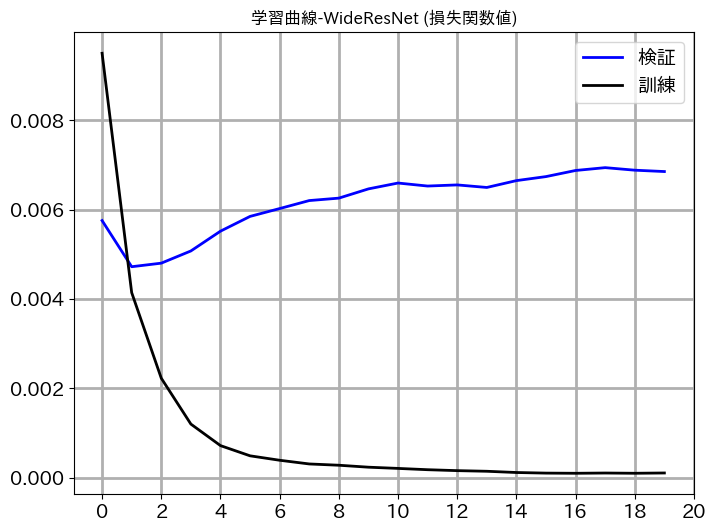

In [ ]:
# 学習曲線 (損失関数値)
plt.figure(figsize=(8,6))
plt.plot(val_loss_list_wr,label='検証', lw=2, c='b')
plt.plot(train_loss_list_wr,label='訓練', lw=2, c='k')
plt.title('学習曲線-WideResNet (損失関数値)')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.xticks(np.arange(0, 21, 2))
plt.show()

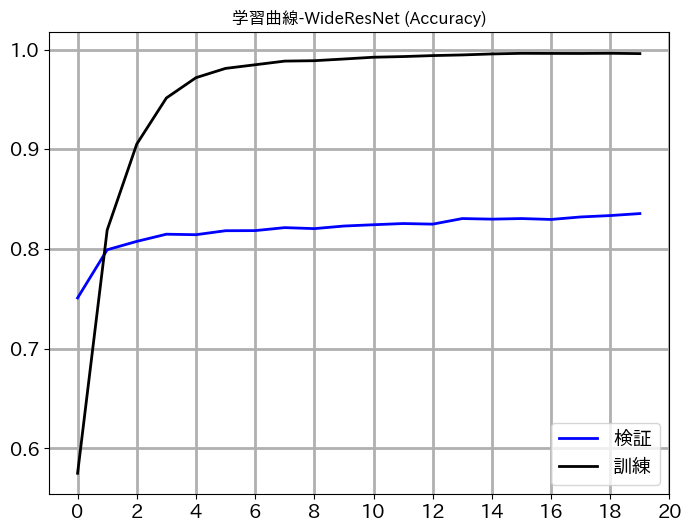

In [ ]:
new_val_acc_list_wr = []
new_train_acc_list_wr = []

for x in val_acc_list_wr:
  t = x.to('cpu').detach().numpy().copy()
  new_val_acc_list_wr.append(t)

for z in train_acc_list_wr:
  s = z.to('cpu').detach().numpy().copy()
  new_train_acc_list_wr.append(s)

# 学習曲線 (Accuracy)
plt.figure(figsize=(8,6))
plt.plot(new_val_acc_list_wr,label='検証', lw=2, c='b')
plt.plot(new_train_acc_list_wr,label='訓練', lw=2, c='k')
plt.title('学習曲線-WideResNet (Accuracy)')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.xticks(np.arange(0, 21, 2))
plt.show()

## 課題
1. ResNet50、WideResNet50以外のモデルを利用して精度がどのように変わるのか確認してみましょう

In [ ]:
# ここにコードを実装
